In [1]:
import sys
import glob
import yaml
import pyart
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('../scripts')
import core
from analyse import bname


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [8]:
colors = {
    'C': 'navy',
    'G': 'seagreen',
    'N': 'orangered',
    'GB':'crimson',
    'CB':'darkorchid',
    'GM':'mediumturquoise',
    'CM':'darkcyan',
}
cmap = 'balance'

## Model Variances

In [3]:
win=100
nbasis=15
exp = 'synth8b'
dataset = 'cohort'

stim_info = pd.read_csv(f"../inputs/stimuli/{exp}-info.csv")
spectrograms = pd.read_csv(f"../build/{exp}/spectrograms.csv", index_col=[0,1])
motifs = stim_info.motif.unique()
gaps = stim_info[stim_info.type=='G'].groupby(['motif','gap']).first()[['gap_start', 'gap_stop']]
gaplocs = gaps.index.levels[1].to_numpy().astype(int)

models = joblib.load(f"../output/{exp}/{dataset}_PLS_models.pkl")
variances = pd.DataFrame(models['variances'])
print(f"Exp {exp} dataset {dataset} mean %variance explained at {models['best_param']} components:",
      variances.T.mean().iloc[models['best_param']]*100)
print(f"Exp {exp} dataset {dataset} std %variance explained at {models['best_param']} components:",
    variances.T.std().iloc[models['best_param']]*100)

Exp synth8b dataset cohort mean %variance explained at 11 components: 14.732801787548288
Exp synth8b dataset cohort std %variance explained at 11 components: 0.4890448751181012


In [4]:
dsetdata = []
for h5file in glob.glob(f"../build/{exp}/**_delemb_win{win}_basis{nbasis}.h5"):
    dsetdata.append(pd.read_hdf(h5file, key='Induction'))
responses = pd.concat(dsetdata, axis=1)

## Example condition spectrograms

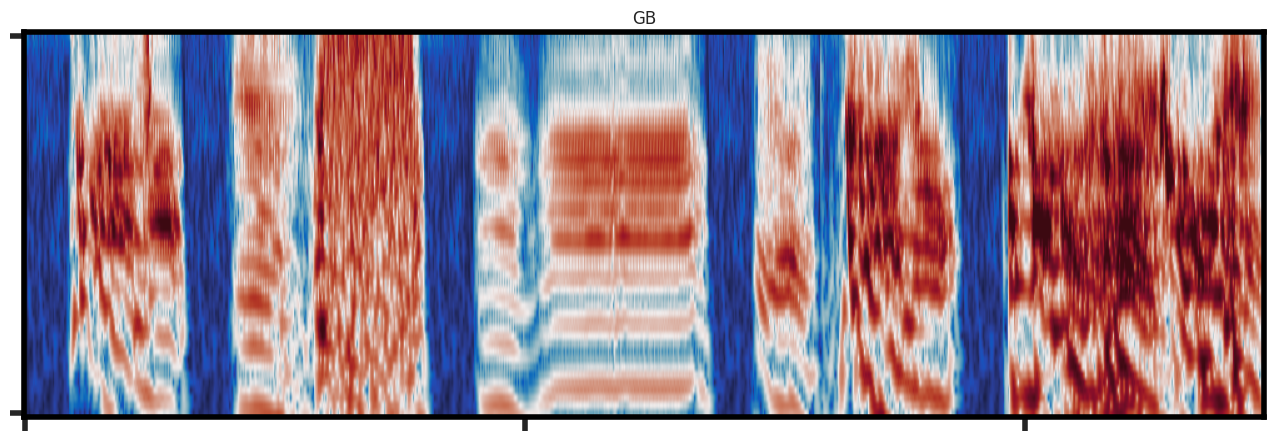

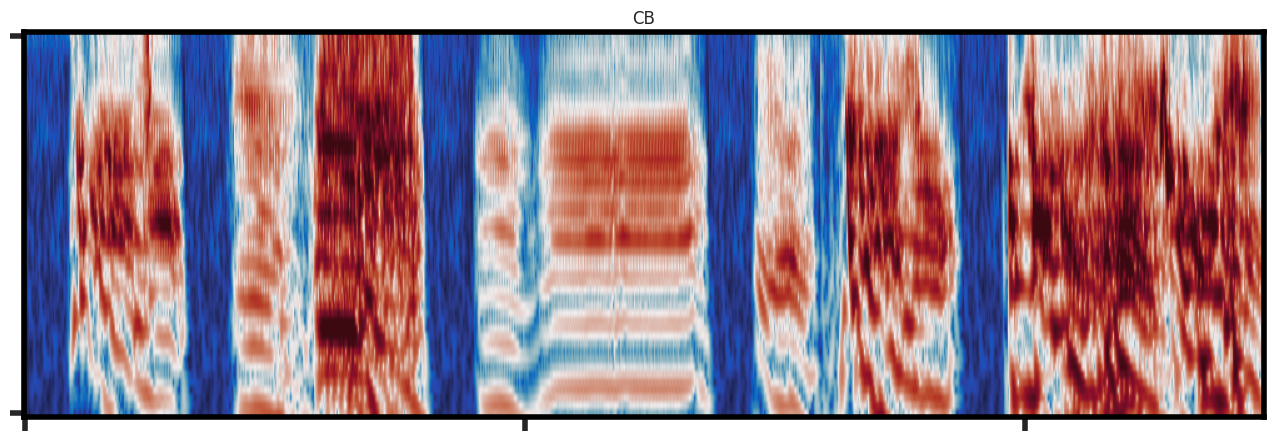

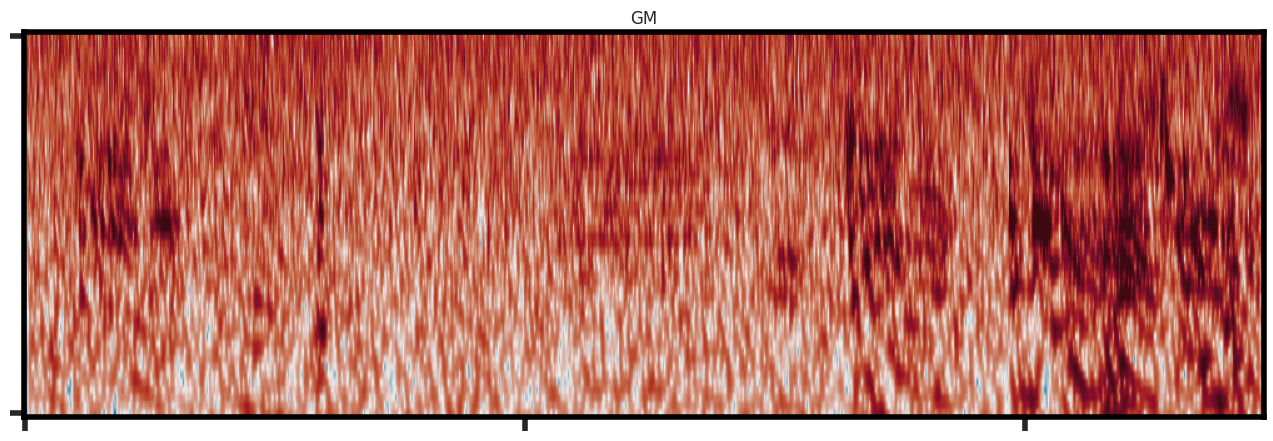

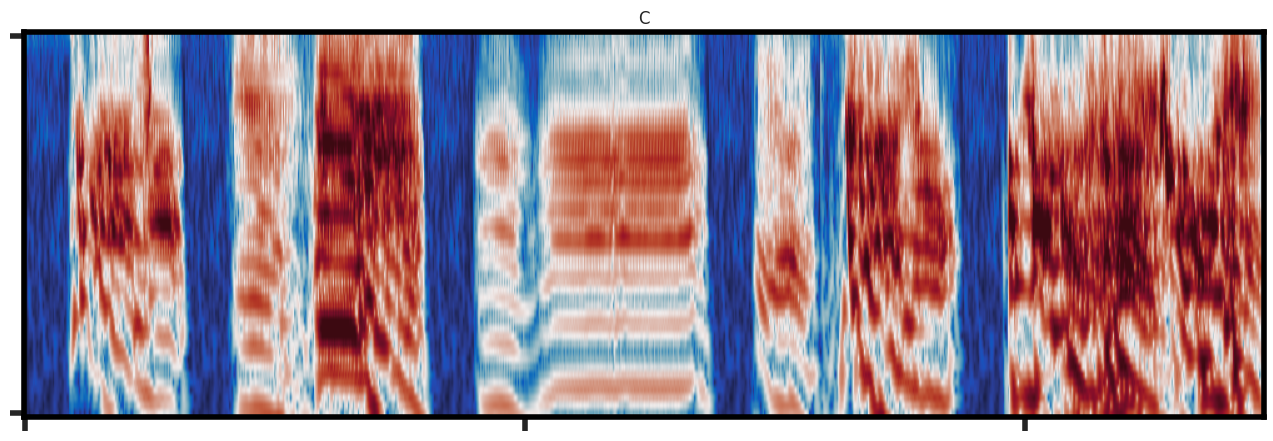

In [11]:

sns.set_style('white')
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 4
plt.rcParams['xtick.minor.size'] = 7
plt.rcParams['xtick.minor.width'] = 2

plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 4
plt.rcParams['ytick.minor.size'] = 7
plt.rcParams['ytick.minor.width'] = 2

m = 'synth8mk2'

for c in ['GB','CB','GM','C']:
    ax = plt.figure(figsize=(16, 5)).add_subplot()
    ax.imshow(spectrograms.loc[bname(m, c, 2)].iloc[:, ::-1].T, aspect='auto', cmap=cmap, vmin=0, vmax=2.7)
    ax.set_yticks([0,49], [])
    ax.set_xticks([0,400,800], [])
    plt.setp(ax.spines.values(), lw=4, color='black')
    ax.set_title(c)

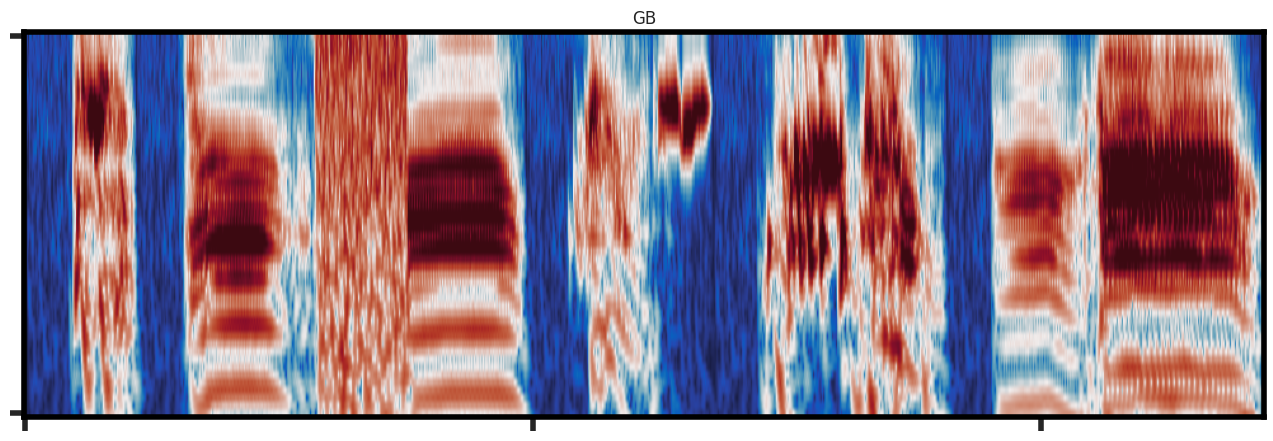

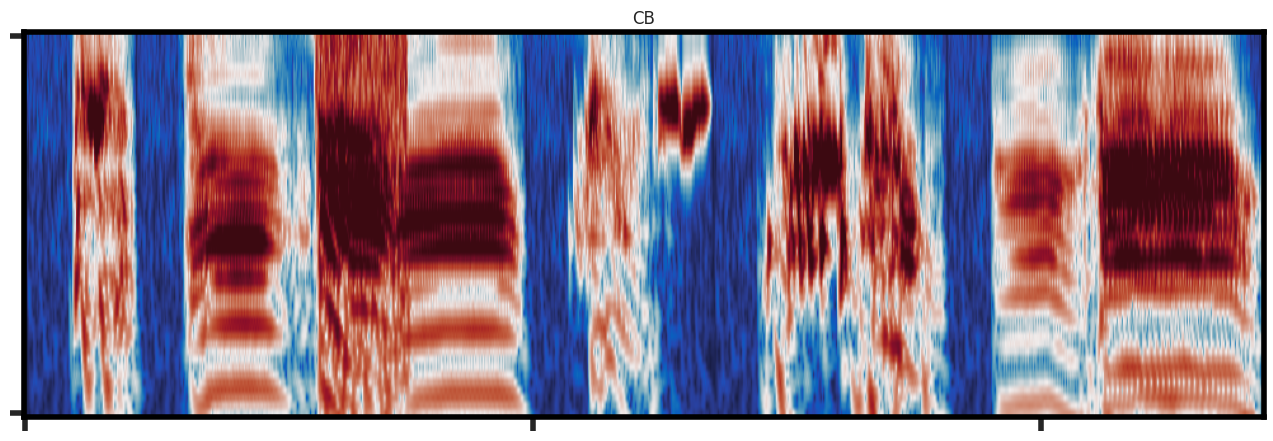

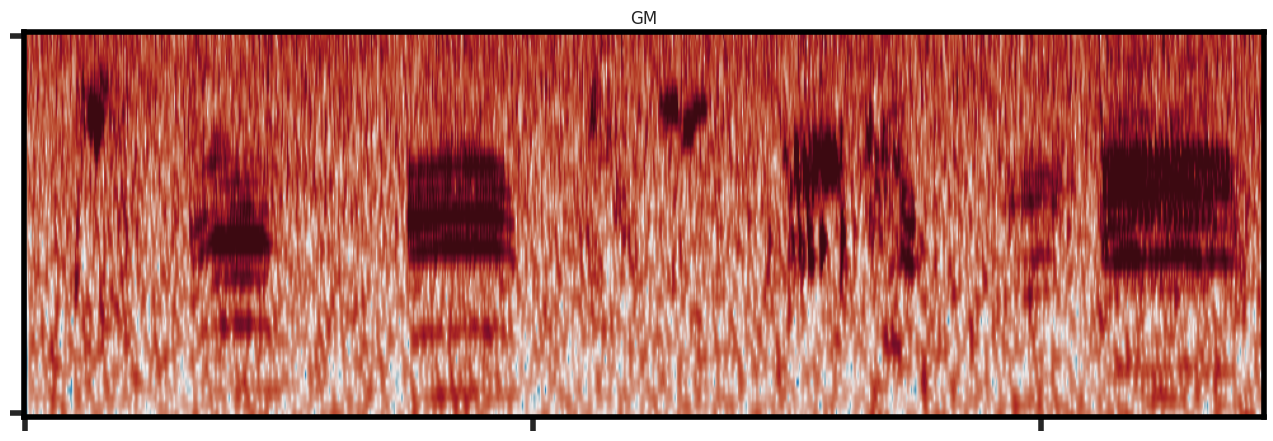

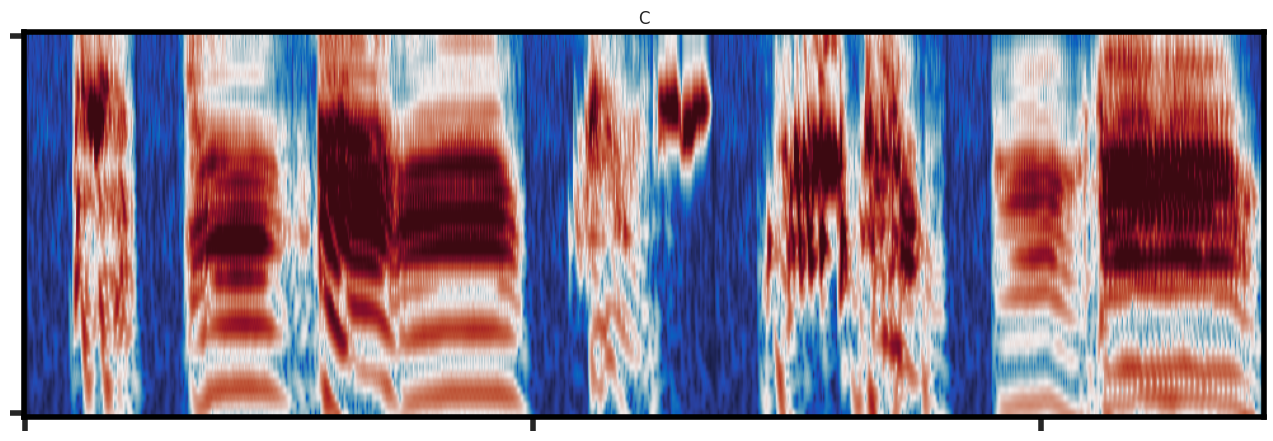

In [10]:
m = 'synth8mk5'
for c in ['GB','CB','GM','C']:
    ax = plt.figure(figsize=(16, 5)).add_subplot()
    ax.imshow(spectrograms.loc[bname(m, c, 2)].iloc[:, ::-1].T, aspect='auto', cmap=cmap, vmin=0, vmax=2.7)
    ax.set_yticks([0,49], [])
    ax.set_xticks([0,400,800], [])
    plt.setp(ax.spines.values(), lw=4, color='black')
    ax.set_title(c)

## First dimension projections

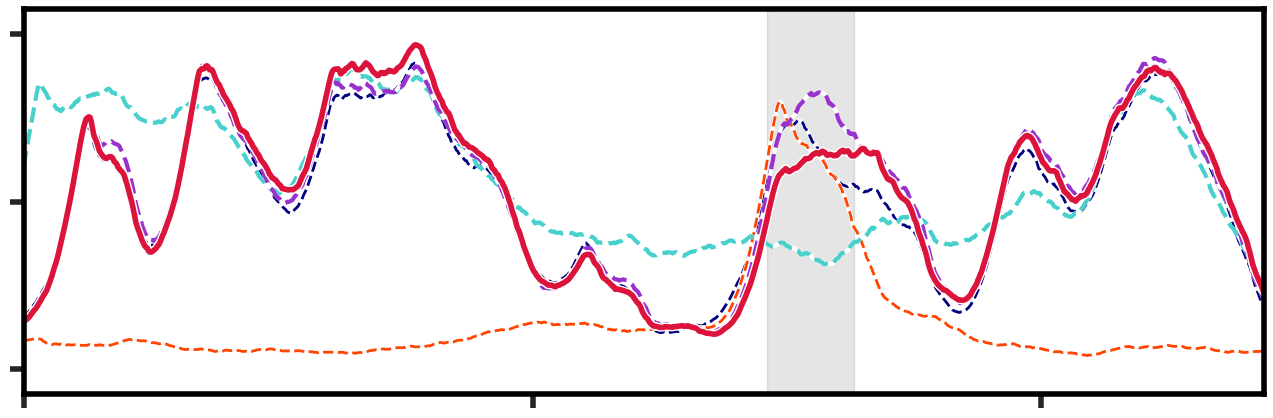

In [14]:
m = 'synth8mk5'
g = 4
tmax = spectrograms.loc[bname(m, 'C', None)].index.max()
model = models[m]
ga, gb = gaps.loc[m].loc[g].astype(int)

conditions = ['C','G','CB','GB','CM','GM','N']
xscores = {}
yscores = {}

cstim = spectrograms.loc[bname(m, 'C', g)]

for c in conditions:
    stim = bname(m, c, g)
    X, Y = model.transform(
        X = responses.loc[stim].loc[cstim.index],
        Y = spectrograms.loc[stim].loc[cstim.index] 
    )
    xscores[c] = X
    yscores[c] = Y

sns.set_style('white')
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 4
plt.rcParams['xtick.minor.size'] = 6
plt.rcParams['xtick.minor.width'] = 2

plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 4
plt.rcParams['ytick.minor.size'] = 6
plt.rcParams['ytick.minor.width'] = 2

dim=0
ax = plt.figure(figsize=(16,5)).add_subplot()

for c in ['C', 'N', 'GM', 'CB']:
    lw = 3 if c in ['GM', 'CB'] else 2
    a = 1 if c in ['GM', 'CB'] else 0.5
    ax.plot(xscores[c][:,dim], color='white', lw=3)
    ax.plot(xscores[c][:, dim], color=colors[c], lw=lw, ls='--', alpha=1)
        
ax.fill_between([ga, gb], -0.3, 4.3, color='black', alpha=0.1)
ax.set_xlim(0,tmax)
ax.set_xticks([0,400,800],[])
plt.setp(ax.spines.values(), lw=4, color='black')
ax.set_yticks([0,2,4], [])
ax.set_ylim(-0.3,4.3)
    
ax.plot(xscores['GB'][:,dim], color='white', lw=6)
ax.plot(xscores['GB'][:,dim], color=colors['GB'], lw=4)
# ax.xaxis.set_minor_locator(AutoMinorLocator())
# ax.yaxis.set_minor_locator(AutoMinorLocator())
# sns.despine(ax=ax, top=True, right=True)

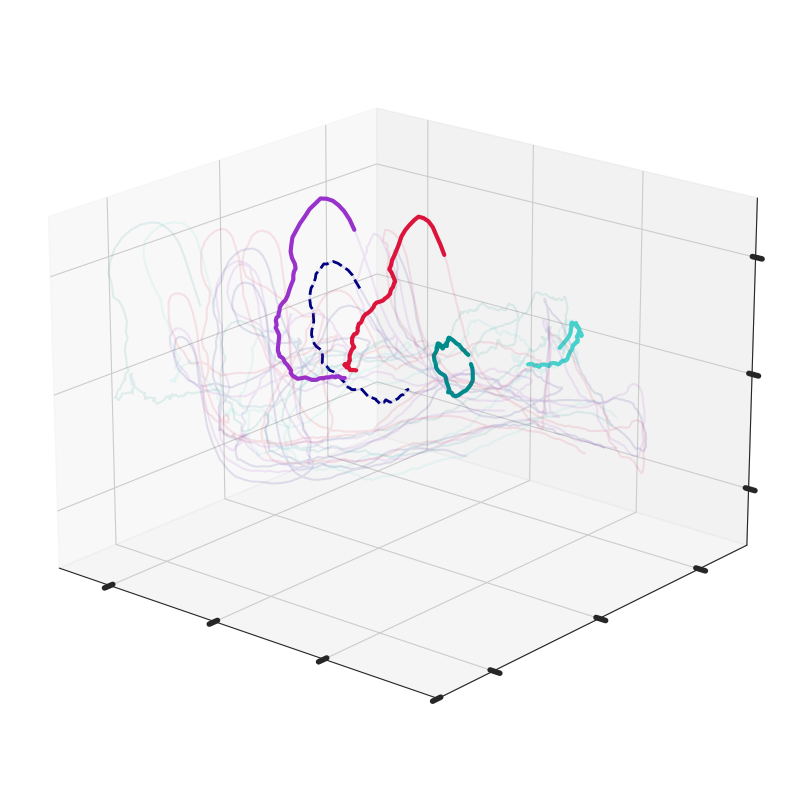

In [15]:
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
for c in ['C', 'CM', 'GM', 'CB', 'GB']:
    lw = 2 if c=='C' else 3
    ls = '--' if c=='C' else '-'
    ax.plot(
        xscores[c][:, 0],
        xscores[c][:, 1],
        xscores[c][:, 2],
        alpha=0.1,
        color=colors[c]
    )
    ax.plot(
        xscores[c][ga:gb, 0],
        xscores[c][ga:gb, 1],
        xscores[c][ga:gb, 2],
        alpha=1,
        lw=lw,
        ls=ls,
        color=colors[c]
    )
    
ax.set_xlim(1, 4.5)
ax.set_xticks([1,2,3,4], [])

ax.set_ylim(-1.5, 1.5)
ax.set_yticks([-1,0,1], [])

ax.set_zlim(-1.5, 1.5)
ax.set_zticks([-1,0,1], [])

plt.setp(ax.spines.values(), lw=4, color='black')
ax.view_init(elev=20, azim=130, roll=0)

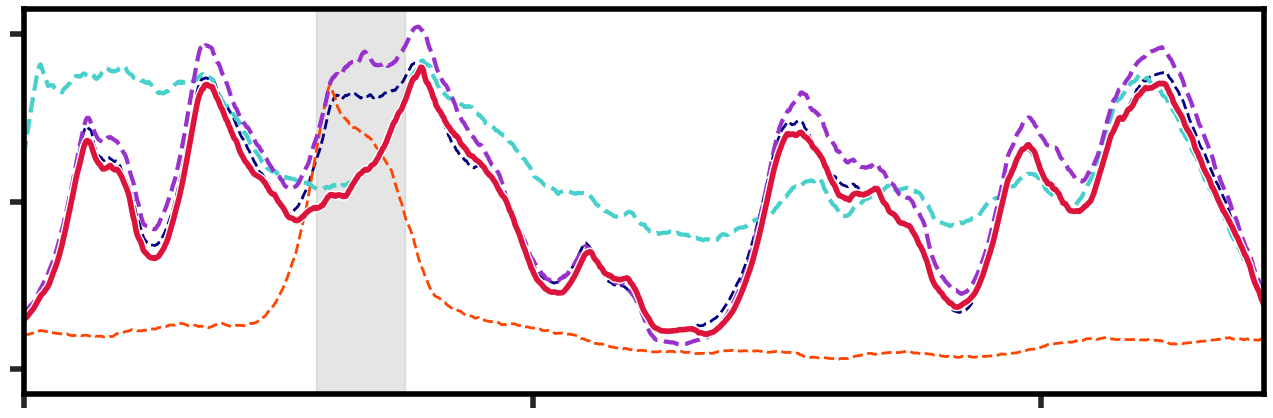

In [17]:
m = 'synth8mk5'
g = 2
tmax = spectrograms.loc[bname(m, 'C', None)].index.max()
model = models[m]
ga, gb = gaps.loc[m].loc[g].astype(int)

conditions = ['C','G','CB','GB','CM','GM','N']
xscores = {}
yscores = {}

cstim = spectrograms.loc[bname(m, 'C', g)]

for c in conditions:
    stim = bname(m, c, g)
    X, Y = model.transform(
        X = responses.loc[stim].loc[cstim.index],
        Y = spectrograms.loc[stim].loc[cstim.index] 
    )
    xscores[c] = X
    yscores[c] = Y

dim=0
ax = plt.figure(figsize=(16,5)).add_subplot()

for c in ['C', 'N', 'GM', 'CB']:
    lw = 3 if c in ['GM', 'CB'] else 2
    a = 1 if c in ['GM', 'CB'] else 0.5
    # ax.plot(xscores[c][:,dim], color='white', lw=3)
    ax.plot(xscores[c][:, dim], color=colors[c], lw=lw, ls='--', alpha=1)
        
ax.fill_between([ga, gb], -0.3, 4.3, color='black', alpha=0.1)
ax.set_xlim(0,tmax)
ax.set_xticks([0,400,800],[])
plt.setp(ax.spines.values(), lw=4, color='black')
ax.set_yticks([0,2,4], [])
ax.set_ylim(-0.3,4.3)
    
ax.plot(xscores['GB'][:,dim], color='white', lw=6)
ax.plot(xscores['GB'][:,dim], color=colors['GB'], lw=4)

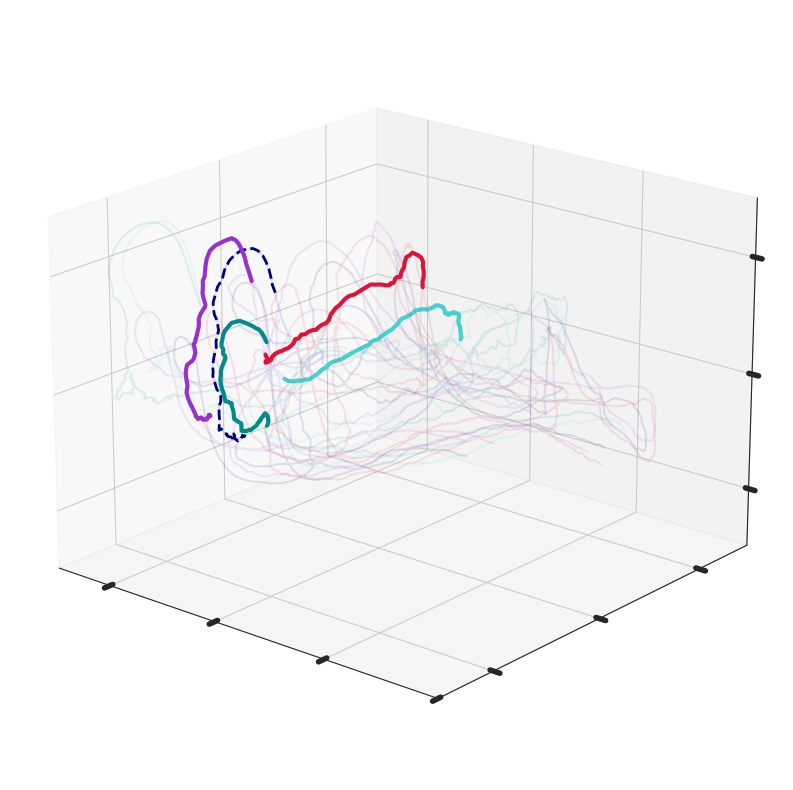

In [18]:
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
for c in ['C', 'CM', 'GM', 'CB', 'GB']:
    lw = 2 if c=='C' else 3
    ls = '--' if c=='C' else '-'
    ax.plot(
        xscores[c][:, 0],
        xscores[c][:, 1],
        xscores[c][:, 2],
        alpha=0.1,
        color=colors[c]
    )
    ax.plot(
        xscores[c][ga:gb, 0],
        xscores[c][ga:gb, 1],
        xscores[c][ga:gb, 2],
        alpha=1,
        lw=lw,
        ls=ls,
        color=colors[c]
    )
ax.set_xlim(1, 4.5)
ax.set_xticks([1,2,3,4],[])

ax.set_ylim(-1.5, 1.5)
ax.set_yticks([-1,0,1], [])

ax.set_zlim(-1.5, 1.5)
ax.set_zticks([-1,0,1], [])

plt.setp(ax.spines.values(), lw=4, color='black')
ax.view_init(elev=20, azim=130, roll=0)

In [19]:
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
for c in ['C', 'GM', 'CB', 'GB']:
    lw = 2 if c=='C' else 3
    ls = '--' if c=='C' else '-'
    ax.plot(
        xscores[c][:, 0],
        xscores[c][:, 1],
        xscores[c][:, 2],
        alpha=0.1,
        color=colors[c]
    )
    ax.plot(
        xscores[c][ga:gb, 0],
        xscores[c][ga:gb, 1],
        xscores[c][ga:gb, 2],
        alpha=1,
        lw=lw,
        ls=ls,
        color=colors[c]
    )
ax.set_xlim(1, 4.5)
ax.set_xticks([1,2,3,4],[])

ax.set_ylim(-1.5, 1.5)
ax.set_yticks([-1,0,1], [])

ax.set_zlim(-1.5, 1.5)
ax.set_zticks([-1,0,1], [])

plt.setp(ax.spines.values(), lw=4, color='black')
ax.view_init(elev=20, azim=130, roll=0)

## Cohort 3, all units result

In [20]:
sns.set_style('whitegrid')

plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 4
plt.rcParams['xtick.minor.size'] = 7
plt.rcParams['xtick.minor.width'] = 2

plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 4
plt.rcParams['ytick.minor.size'] = 7
plt.rcParams['ytick.minor.width'] = 2

In [22]:
scores = pd.read_csv(
    f"../output/{exp}/distances-cohort.csv",
).set_index(['motif','gap','comp'])
scores.head()

score
motif     gap comp          
synth8mk0 2.0 GBCB  1.068653
              GBC   1.025432
              GBN   1.894118
              GBG   2.403935
              GBGM  1.064490

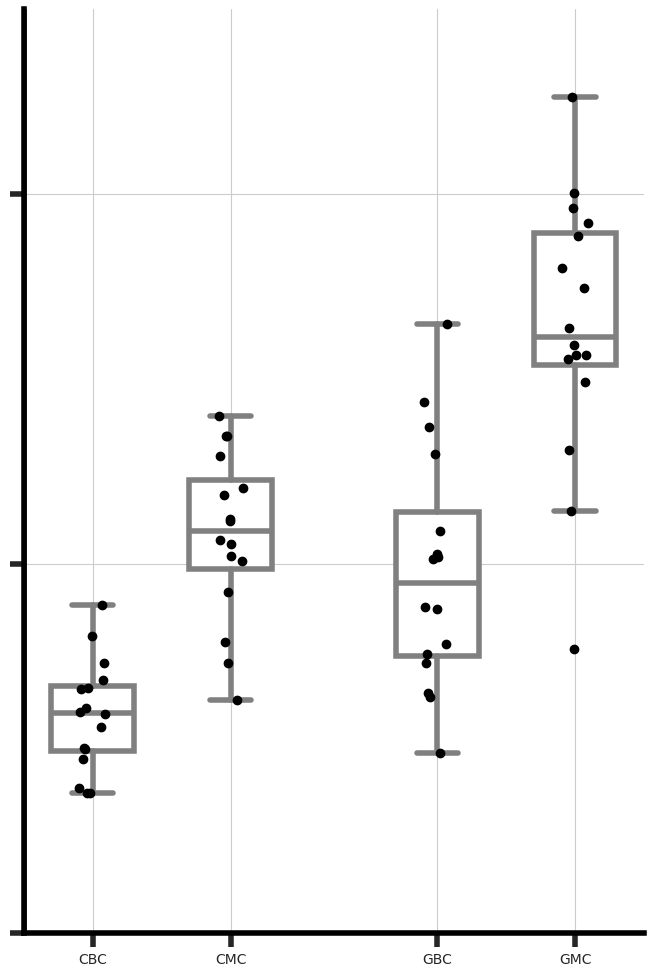

In [23]:
fig, ax = plt.subplots(1,1, figsize=(8,12))

positions = [0,1,2.5,3.5]
dt = scores.unstack('comp').droplevel(0,axis=1)
bp1 = ax.boxplot(
    dt[['CBC', 'CMC']],
    patch_artist=True,
    showfliers=False,
    positions = positions[:2],
    widths=0.6
)
bp2 = ax.boxplot(
    dt[['GBC', 'GMC',]],
    patch_artist=True,
    showfliers=False,
    positions = positions[2:],
    widths=0.6
)

for icd, cd in enumerate(['CBC','CMC','GBC','GMC']):
    ax.plot(
        np.repeat(positions[icd], 16) + np.random.uniform(-0.1,0.1,16),
        dt[cd], marker='o', ls='', alpha=1, color='black',
        zorder=10
    )

for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bp1[element], color='grey', lw=4)
    plt.setp(bp2[element], color='grey', lw=4)

for patch, tag in zip(bp1['boxes'], ['CB', 'CM']):
    patch.set(facecolor='white')
for patch, tag in zip(bp2['boxes'], ['GB', 'GM']):
    patch.set(facecolor='white')
        
ax.set_xticks([0,1,2.5,3.5], ['CBC','CMC','GBC','GMC'])
ax.set_yticks([0,1,2], [])
ax.set_ylim(0,2.5)

plt.setp(ax.spines.values(), lw=4, color='black')
sns.despine(ax=ax, top=True, right=True)
ax.axvline(-0.5, lw=4, color='black')
ax.axhline(0, lw=2, color='black')

In [24]:
fig, ax = plt.subplots(1,1, figsize=(8,12))

bp1 = ax.boxplot(
    dt[['GBC', 'GBCB', 'GBGM', 'GBN']],
    patch_artist=True,
    showfliers=False,
    positions = [0,1,2,3],
    widths=0.6
)
for icd, cd in enumerate(['GBC', 'GBCB', 'GBGM', 'GBN']):
    ax.plot(
        np.repeat(icd, 16) + np.random.uniform(-0.1,0.1,16),
        dt[cd], marker='o', ls='', alpha=1, color='black',
        zorder=10
    )

for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bp1[element], color='grey', lw=4)
for patch in bp1['boxes']:
    patch.set(facecolor='white')

ax.set_xticks([0,1,2,3], ['GBC', 'GBCB', 'GBGM', 'GBN'])
ax.set_yticks([0,1,2],[])
# ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_ylim(0,2.5)

plt.setp(ax.spines.values(), lw=4, color='black')
sns.despine(ax=ax, top=True, right=True)
ax.axvline(-0.5, lw=5, color='black')
ax.axhline(0, lw=4, color='black')

In [25]:
fig, ax = plt.subplots(1,1, figsize=(5,10))

bp1 = ax.boxplot(
    dt[['GBCB', 'GBGM']],
    patch_artist=True,
    positions = [0,1],
    widths=0.6
)
for icd, cd in enumerate(['GBCB', 'GBGM']):
    ax.plot(np.repeat(icd, 16), dt[cd], marker='o', ls='', alpha=1, color='black')

for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bp1[element], color='black', lw=4)
for patch in bp1['boxes']:
    patch.set(facecolor='white')

ax.set_xticks([0,1], ['GBCB','GBGM'])
ax.set_yticks([0,1,2],[])
# ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_ylim(0,2)

plt.setp(ax.spines.values(), lw=4, color='black')
sns.despine(ax=ax, top=True, right=True)
ax.axvline(-0.5, lw=5, color='black')
ax.axhline(0, lw=4, color='black')